## Off-Policy Monte-Carlo Control

Here is the implementation of off-policy Monte-Carlo control using weighted imporatance sampling and $\epsilon$-greedy policy improvement. The policy evaluation algorithm is implemented using every-visit incremental update.

Algorithm is run on openai.gym Blackjack-v0 environment.


In [0]:
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import sys
import gym
from gym import logger as gymlogger
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

## Blackjack environment

A state in Blackjask is defined by three things:<br/>
1. Player current sum (1-31)
2. Dealer's one showing card (1-10)
3. Does player holds a usable ace (0 or 1)

In [2]:
env = gym.make("Blackjack-v0")
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Off-Policy MC Implementation

In [0]:
def get_epsilon_greedy_policy(env, q_values, epsilon = 0.6):
    """
    an epsilon-greedy policy
    1. Behavior Policy if epsilon is large
    2. Greedy policy if epsilon = 0

    Returns:
        policy: an epsilon-soft policy which takes greedy action with probability 1-epsilon
                and take any random action with probability epsilon
    """
    num_actions = env.action_space.n

    def policy(state):
        if state not in q_values:
            return np.ones((num_actions), dtype=float) / num_actions
        greedy_action = q_values[state].argmax()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

def sample_episode(env, policy):
    """
    Sample an episode using given policy
    """

    state = env.reset()
    episode = []
    num_actions = env.action_space.n
    while True:
        action_probs = policy(state)
        action = np.random.choice(np.arange(num_actions), p=action_probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state,action,reward))
        if done:
            break
        state = next_state
    return episode

In [0]:
def MC_control_off_policy(env, num_episodes=10000, gamma=1.0, alpha=0.015):
    """
    Performs off-policy MC control using weighted importance sampling

    Args:
        env: Learning enviroment, e.g. Blackjack
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        alpha: Learning rate
    Returns:
        q_values: dictionary mapping states (tuple) to array of action values
                  i.e. s -> np.array([q(s,a1),q(s,a2),...])
        policy: the final (~optimal) greedy policy
    """

    q_values = defaultdict(lambda: np.zeros(env.action_space.n))

    for episode_num in range(num_episodes):
        if (episode_num+1) % 1000 == 0:
            print("\rFinished {}/{} episodes".format(episode_num+1,num_episodes), end="")
            sys.stdout.flush()
        mu = get_epsilon_greedy_policy(env, q_values) # Behavior Policy
        episode = sample_episode(env, mu)
        current_return = 0
        T = len(episode)
        W = 1
        for t in reversed(range(T)):
            state, action, reward = episode[t]
            current_return = gamma*current_return + reward
            q_values[state][action] += alpha*W*(current_return - (gamma*q_values[state][action]))
            if q_values[state].argmax() != action:
                break
            W = W*(1.0/mu(state)[action])
        mu = get_epsilon_greedy_policy(env, q_values)

    policy = get_epsilon_greedy_policy(env, q_values, epsilon=0.0)
    return q_values, policy

## Helper Functions to Plot State Values and Policy

In [0]:
# Following function to plot the Blackjack value function is based on the
# implementation here: https://github.com/dennybritz/reinforcement-learning/

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x, max_x = 11, 22
    min_y, max_y = min(k[1] for k in V.keys()), max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, ax, title):
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)

    fig = plt.figure(figsize=(20, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    plot_surface(X, Y, Z_noace, ax1, "{} (No Usable Ace)".format(title))
    ax2 = fig.add_subplot(122, projection='3d')
    plot_surface(X, Y, Z_ace, ax2, "{} (Usable Ace)".format(title))

In [0]:
def plot_policy(policy, title):
    x_range = np.arange(11, 22)
    y_range = np.arange(10, 0, -1)
    X, Y = np.meshgrid(x_range, y_range)

    # Optimal actions - Break ties in favor of Hit (since states with lower
    # deck values are less frequently sampled, and are always hit)
    Z_noace = np.array([[0 if policy((x,y,0))[0] > policy((x,y,0))[1] else 1 for x in x_range] for y in y_range])
    Z_ace = np.array([[0 if policy((x,y,1))[0] > policy((x,y,1))[1] else 1 for x in x_range] for y in y_range])

    def plot_grid(X, Y, Z, ax, title):
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_title(title)
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(121)
    plot_grid(X, Y, Z_noace, ax1, "{} (No Usable Ace)".format(title))
    ax2 = fig.add_subplot(122)
    plot_grid(X, Y, Z_ace, ax2, "{} (Usable Ace)".format(title))

## Run Model and Plot Results

In [7]:
q_values, policy = MC_control_off_policy(env, num_episodes=500000, gamma=1.0, alpha=0.015)

Finished 500000/500000 episodes

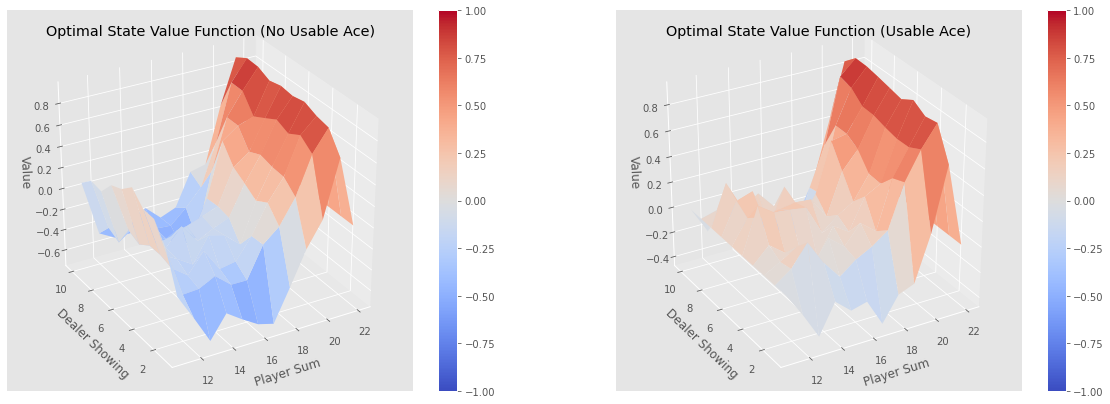

In [8]:
v_values = defaultdict(float)
for state,actions in q_values.items():
    max_action_value = np.max(actions)
    v_values[state] = max_action_value

plot_value_function(v_values, "Optimal State Value Function")

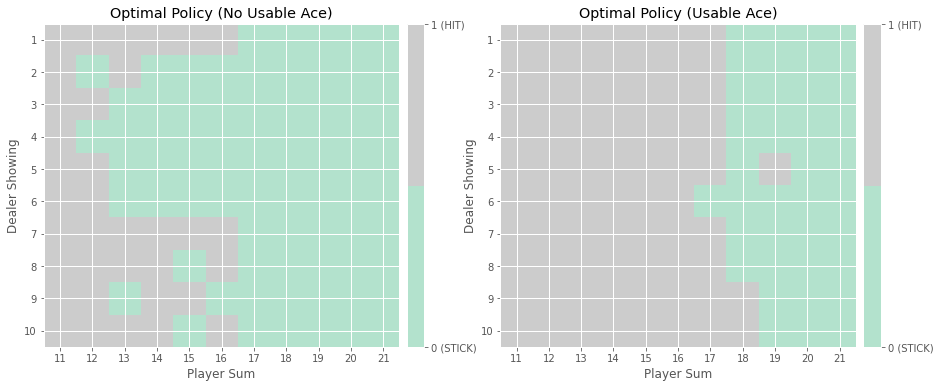

In [9]:
plot_policy(policy, "Optimal Policy")